<a href="https://colab.research.google.com/github/Ali-Alameer/Deep-Learning/blob/main/week6_tensorflowhub_with_your_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow Hub


[TensorFlow Hub](https://tfhub.dev/) is a repository of pre-trained TensorFlow models.

This workshop demonstrates how to:

1. Use models from TensorFlow Hub with `tf.keras`.
1. Use an image classification model from TensorFlow Hub.
1. Do simple transfer learning to fine-tune a model for your own image classes.

## Setup

In [3]:
!pip install tensorflow-hub



import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached tf_keras-2.15.1-py3-none-any.whl.metadata (1.7 kB)
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
  Using cached tf_keras-2.15.0-py3-none-any.whl.metadata (1.6 kB)
Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl (30 kB)
Using cached tf_keras-2.15.0-py3-none-any.whl (1.7 MB)


## An ImageNet classifier

You'll start by using a classifier model pre-trained on the [ImageNet](https://en.wikipedia.org/wiki/ImageNet) benchmark dataset—no initial training required!

### Download the classifier

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model [from TensorFlow Hub](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2) and wrap it as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Any <a href="https://tfhub.dev/s?q=tf2&module-type=image-classification/" class="external">compatible image classifier model</a> from TensorFlow Hub will work here, including the examples provided in the drop-down below.

In [4]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

In [43]:
import tf_keras
IMAGE_SHAPE = (224, 224)

classifier = tf_keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

### Run it on a single image

Download a single image to try the model on:

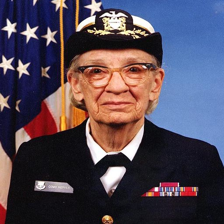

In [44]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [45]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Add a batch dimension (with `np.newaxis`) and pass the image to the model:

In [46]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 5s 5s/step


(1, 1001)

The result is a 1001-element vector of logits, rating the probability of each class for the image.

The top class ID can be found with `tf.math.argmax`:

In [50]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=653>

### Decode the predictions

Take the `predicted_class` ID (such as `653`) and fetch the ImageNet dataset labels to decode the predictions:

In [10]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

10484/10484 [==============================] - 0s 0us/step


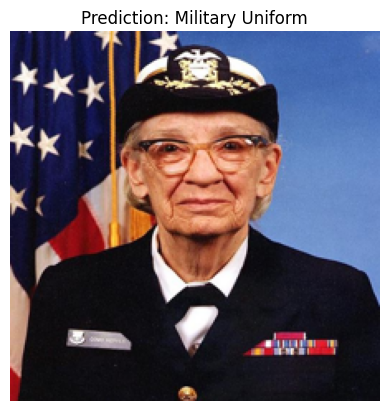

In [56]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
plotted = plt.title("Prediction: " + predicted_class_name.title())

## Simple transfer learning

But what if you want to create a custom classifier using your own dataset that has classes that aren't included in the original ImageNet dataset (that the pre-trained model was trained on)?

To do that, you can:

1. Select a pre-trained model from TensorFlow Hub; and
2. Retrain the top (last) layer to recognize the classes from your custom dataset.

### Dataset

In this example, you will use the unversity of Salford buildings dataset:

In [12]:
import pathlib
dataset_url = "https://salford.figshare.com/ndownloader/files/36524085"
data_dir = tf.keras.utils.get_file('dataset', origin=dataset_url, untar=True, cache_dir = '/content')
data_dir = pathlib.Path(data_dir)

3037144022/3037144022 [==============================] - 61s 0us/step


If you have your dataset collected by yourself, upload to your google drive and use the below code:

In [13]:
#from google.colab import drive
#drive.mount('/content/drive')
#import pathlib
#data_dir = "/content/drive/MyDrive/dataset/"
#data_dir = pathlib.Path(data_dir)

First, load this data into the model using the image data off disk with `tf.keras.utils.image_dataset_from_directory`, which will generate a `tf.data.Dataset`:

In [14]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [15]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 751 files belonging to 10 classes.
Using 601 files for training.


In [16]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 751 files belonging to 10 classes.
Using 150 files for validation.


In [17]:
train_ds = train_dataset
val_ds = validation_dataset

See classes of the dataset:

In [18]:
class_names = np.array(train_ds.class_names)
print(class_names)

['Chapman' 'Cockcroft' 'Library' 'Maxwell' 'Media City Campus'
 'New Adelphi' 'New Science' 'Newton' 'Sports Center' 'University House']


Second, because TensorFlow Hub's convention for image models is to expect float inputs in the `[0, 1]` range, use the `tf.keras.layers.Rescaling` preprocessing layer to achieve this.

Note: You could also include the `tf.keras.layers.Rescaling` layer inside the model. Refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide for a discussion of the tradeoffs.

In [19]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [20]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


2024-10-24 13:53:56.898255: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Run the classifier on a batch of images

Now, run the classifier on an image batch:

In [22]:
result_batch = classifier.predict(train_ds)

19/19 [==============================] - 6s 187ms/step


In [23]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['chainlink fence', 'crate', 'cinema', 'steel arch bridge',
       'solar dish', 'mobile home', 'airship', 'monastery', 'library',
       'patio', 'cinema', 'patio', 'planetarium', 'garbage truck', 'pier',
       'flagpole', 'freight car', 'prison', 'patio', 'monastery',
       'apiary', 'prison', 'barn', 'picket fence', 'turnstile',
       'container ship', 'scoreboard', 'library', 'patio', 'prison',
       'freight car', 'cab', 'cinema', 'mobile home', 'tile roof',
       'mobile home', 'crate', 'tile roof', 'monastery', 'patio',
       'prison', 'birdhouse', 'prison', 'flagpole', 'solar dish',
       'palace', 'bell cote', 'obelisk', 'triumphal arch', 'mobile home',
       'palace', 'prison', 'space shuttle', 'street sign', 'boathouse',
       'prison', 'street sign', 'library', 'prison', 'palace', 'crane',
       'freight car', 'prison', 'tile roof', 'tile roof', 'mobile home',
       'mobile home', 'steel arch bridge', 'swing', 'palace',
       'greenhouse', 'library', 'tile

Check how these predictions line up with the images:

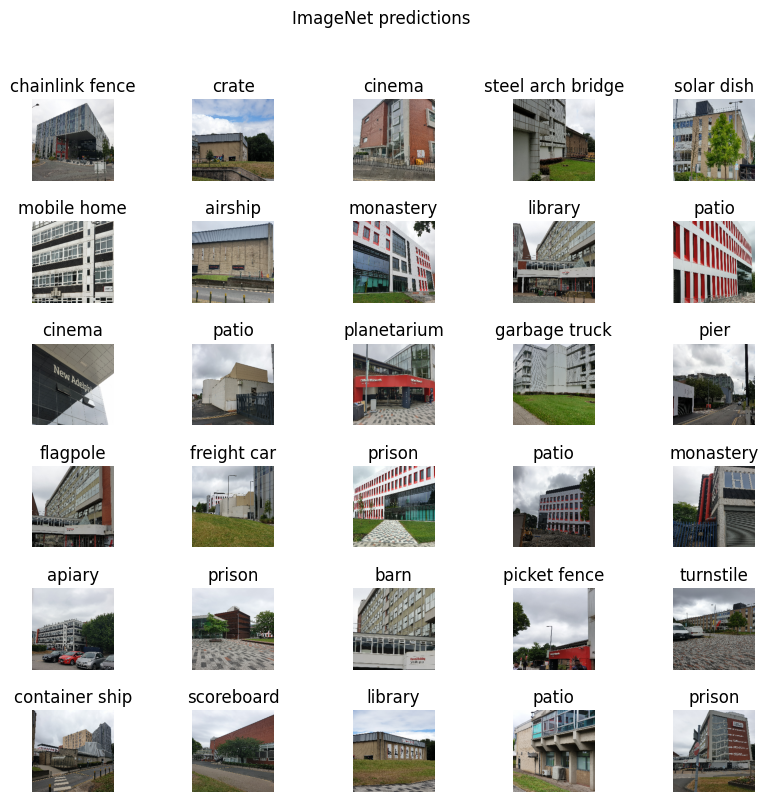

In [24]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

The results are far from perfect, but reasonable considering that these are not

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" class="external">from TensorFlow Hub</a>. Any <a href="https://tfhub.dev/s?module-type=image-feature-vector&q=tf2" class="external">compatible image feature vector model</a> from TensorFlow Hub will work here, including the examples from the drop-down menu.

In [25]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

Create the feature extractor by wrapping the pre-trained model as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Use the `trainable=False` argument to freeze the variables, so that the training only modifies the new classifier layer:

In [26]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

The feature extractor returns a 1280-long vector for each image (the image batch size remains at 32 in this example):

In [27]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


### Attach a classification head

To complete the model, wrap the feature extractor layer in a `tf.keras.Sequential` model and add a fully-connected layer for classification:

In [28]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2270794 (8.66 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [29]:
predictions = model(image_batch)

In [30]:
predictions.shape

TensorShape([32, 10])

### Train the model

Use `Model.compile` to configure the training process and add a `tf.keras.callbacks.TensorBoard` callback to create and store logs:

In [31]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

Now use the `Model.fit` method to train the model.

To keep this example short, you'll be training for just 10 epochs. To visualize the training progress in TensorBoard later, create and store logs an a [TensorBoard callback](https://www.tensorflow.org/tensorboard/get_started#using_tensorboard_with_keras_modelfit).

In [32]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
19/19 [==============================] - 7s 274ms/step - loss: 2.1418 - acc: 0.2596 - val_loss: 1.6104 - val_acc: 0.4933
Epoch 2/10
19/19 [==============================] - 4s 192ms/step - loss: 1.3706 - acc: 0.5857 - val_loss: 1.1144 - val_acc: 0.6867
Epoch 3/10
19/19 [==============================] - 4s 193ms/step - loss: 0.9375 - acc: 0.7854 - val_loss: 0.8661 - val_acc: 0.7533
Epoch 4/10
19/19 [==============================] - 4s 197ms/step - loss: 0.7013 - acc: 0.8636 - val_loss: 0.7235 - val_acc: 0.8200
Epoch 5/10
19/19 [==============================] - 4s 195ms/step - loss: 0.5544 - acc: 0.9101 - val_loss: 0.6308 - val_acc: 0.8533
Epoch 6/10
19/19 [==============================] - 4s 193ms/step - loss: 0.4499 - acc: 0.9368 - val_loss: 0.5657 - val_acc: 0.8733
Epoch 7/10
19/19 [==============================] - 4s 195ms/step - loss: 0.3738 - acc: 0.9567 - val_loss: 0.5178 - val_acc: 0.8733
Epoch 8/10
19/19 [==============================] - 4s 197ms/step - loss: 0.

Start the TensorBoard to view how the metrics change with each epoch and to track other scalar values:

In [33]:
%tensorboard --logdir logs/fit

<!-- <img class="tfo-display-only-on-site" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/images/tensorboard_transfer_learning_with_hub.png?raw=1"/> -->

### Check the predictions

Obtain the ordered list of class names from the model predictions:

In [34]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 0s 368ms/step
['New Adelphi' 'Sports Center' 'Maxwell' 'Library' 'Newton' 'Cockcroft'
 'Sports Center' 'New Science' 'Maxwell' 'New Science' 'New Adelphi'
 'Chapman' 'Library' 'New Adelphi' 'Chapman' 'Maxwell' 'Chapman'
 'New Science' 'New Science' 'Cockcroft' 'Cockcroft' 'Chapman' 'Maxwell'
 'Library' 'Newton' 'Sports Center' 'Maxwell' 'Sports Center'
 'University House' 'Maxwell' 'Chapman' 'Maxwell']


Plot the model predictions:

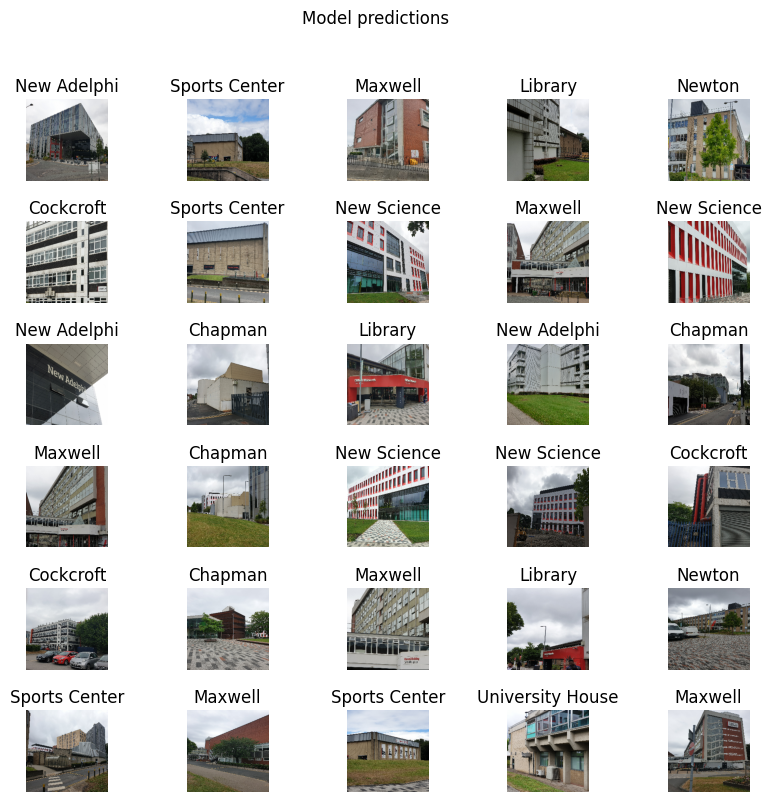

In [35]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Export and reload your model

Now that you've trained the model, export it as a SavedModel for reusing it later.

In [36]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1729774499/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1729774499/assets


'/tmp/saved_models/1729774499'

Confirm that you can reload the SavedModel and that the model is able to output the same results:

In [37]:
reloaded = tf.keras.models.load_model(export_path)

In [38]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

1/1 [==============================] - 0s 341ms/step


In [39]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [40]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

['New Adelphi' 'Sports Center' 'Maxwell' 'Library' 'Newton' 'Cockcroft'
 'Sports Center' 'New Science' 'Maxwell' 'New Science' 'New Adelphi'
 'Chapman' 'Library' 'New Adelphi' 'Chapman' 'Maxwell' 'Chapman'
 'New Science' 'New Science' 'Cockcroft' 'Cockcroft' 'Chapman' 'Maxwell'
 'Library' 'Newton' 'Sports Center' 'Maxwell' 'Sports Center'
 'University House' 'Maxwell' 'Chapman' 'Maxwell']


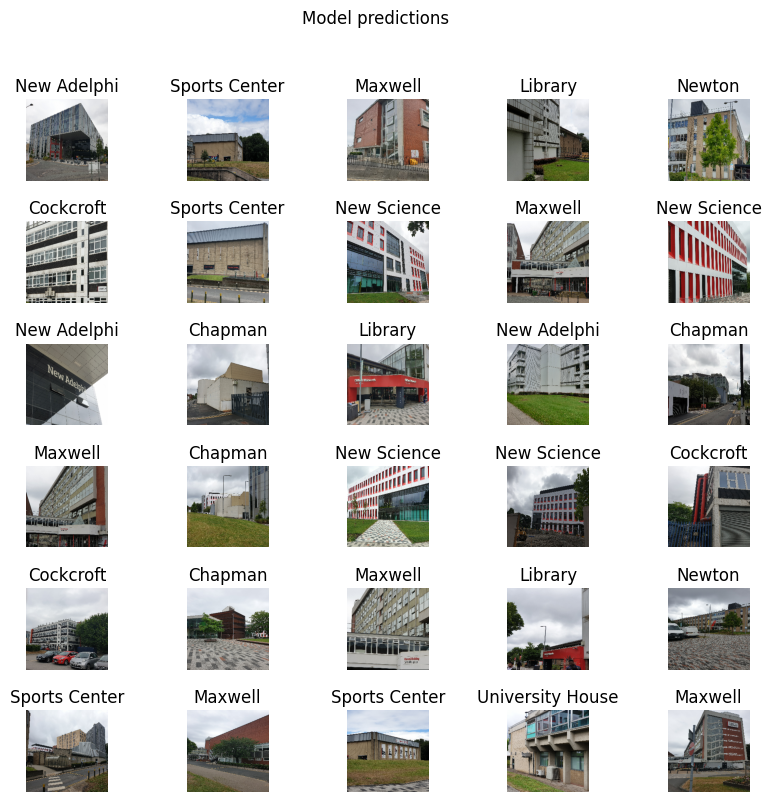

In [41]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

You can use the SavedModel to load for inference or convert it to a [TensorFlow Lite](https://www.tensorflow.org/lite/models/convert/)  model (for on-device machine learning) or a [TensorFlow.js](https://www.tensorflow.org/js/tutorials#convert_pretrained_models_to_tensorflowjs) model (for machine learning in JavaScript).
